In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import operator
import scipy.stats
from scipy.stats.stats import pearsonr

import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt

import os
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh import palettes

import bokeh.models as bmo

import seaborn as sns

In [2]:
output_notebook()

Loading BokehJS ...

In [18]:
data_path = '../Romain/data/'
figures_path = '../Romain/figures/'
#data_path = '../Data/'

In [4]:
path_to_datasets = data_path + 'related_datasets/'

In [5]:
inputs_path = data_path + 'inputs/'
intermediate_path = data_path + 'intermediate/'
output_path = data_path + 'outputs/with_irrig/'

base_path = inputs_path + 'Base/'
diet_path = inputs_path + 'diet/'
pop_path = inputs_path + 'population/'

data_2000_no_irrig_path = intermediate_path + 'Baseline_df_iterations/'
data_2000_path = intermediate_path + 'Baseline_df_iterations/with_irrig/'

#data_2050_no_irrig_path = intermediate_path + 'Future_dfs/All_change/'
data_2050_path = intermediate_path + 'Future_dfs/All_change+irrig/'

data_2050_gdp_cont_path = data_2050_path + 'gdp_cont/original/'
data_2050_gdp_income_path = data_2050_path + 'gdp_cat_income/original/'
data_2050_gdp_stat_path = data_2050_path + 'gdp_cat_stat/original/'

data_2050_gdp_cont_clustered_path = data_2050_path + 'gdp_cont/clustered/'
data_2050_gdp_income_clustered_path = data_2050_path + 'gdp_cat_income/clustered/'
data_2050_gdp_stat_clustered_path = data_2050_path + 'gdp_cat_stat/clustered/'

model_output_path = output_path + 'model_output/'
composite_path = output_path + 'composite/'
compare_path = output_path + 'compare/'
suff_path = output_path + 'sufficiency/'


figure_path = 'figures/with_irrig/'
dist_figures_path = figure_path + 'distributions/'
agg_assumption_fig_path = figure_path + 'agg_assumption/'
cluster_fig_path = figure_path + 'clusters/'
convex_hull_fig_path = figure_path + 'convex_hull/'
suff_fig_path = figure_path + 'sufficiency/'
model_fig_path = figure_path + 'models/'
sensitivity_fig_path = figure_path + 'sensitivity/'

model_path = data_path + 'models/'

# Import & Join datasets

## Sufficiencies

In [6]:
path_to_suff = os.path.join(path_to_datasets,'sufficiencies_input.csv')
suff = pd.read_csv(path_to_suff).drop(['Unnamed: 0', 'get_below'], axis=1)

In [7]:
# Cases: all_ssp column
#0: down in all scenario 
#1: down in most scenario 
#2: variable 
#3: up in most scenario 
#4: up in all scenario
suff = suff.rename({'all_ssp': 'delta_consistency'}, axis=1)

In [8]:
suff.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0


In [39]:
len(suff)

166

## Import independency

In [9]:
path_to_gpck = os.path.join(path_to_datasets,'Import_independency/Matti_Kummu_2019/shp_trade_dep.gpkg')
import_indep = gpd.read_file(path_to_gpck)#, layer='countries')

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRin

IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null

IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not cont

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements

Shell is not a LinearRing
IllegalArgumentException: geometries must not contain null elements



In [129]:
imports_data = import_indep[['cntry', 'admin','country','yr2013']]
imports_data.head()

,cntry,admin,country,yr2013
0,None,Saint Barthelemy,None,NaN
1,None,Jersey,None,NaN
2,None,Ashmore and Cartier Islands,None,NaN
3,None,Siachen Glacier,None,NaN
4,None,Indian Ocean Territories,None,NaN


In [130]:
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries_names.head()

,id,ISO3,adm0_a3,name,nev_admin_name,fao_producer_prices_name,nev_name,nev_name_long,sovereignt,base_id,...,iana_internet,un_vehicle,ioc_olympic,un_iso_numeric,itu_calling,UNI,UNDP,FAOSTAT,GAU,FAOSTAT_augmented
0,1,ABW,ABW,Aruba,Aruba,Aruba,Aruba,Aruba,Netherlands,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1533
1,2,AFG,AFG,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,1,...,.af,AFG,AFG,4.0,93,4.0,AFG,2.0,1.0,2
2,3,AGO,AGO,Angola,Angola,Angola,Angola,Angola,Angola,2,...,.ao,NaN,ANG,24.0,244,24.0,ANG,7.0,8.0,7
3,4,AIA,AIA,Anguilla,Anguilla,Anguilla,Anguilla,Anguilla,United Kingdom,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1660
4,5,ALB,ALB,Albania,Albania,Albania,Albania,Albania,Albania,4,...,.al,AL,ALB,8.0,355,8.0,ALB,3.0,3.0,3


In [131]:
# merge import with country_names to add ISO3 columns
imports = imports_data.merge(countries_names[['ISO3', 'name']], left_on='admin', right_on='name', how='right')
imports.head()

,cntry,admin,country,yr2013,ISO3,name
0,None,Saint Barthelemy,None,NaN,BLM,Saint Barthelemy
1,None,Jersey,None,NaN,JEY,Jersey
2,None,Siachen Glacier,None,NaN,KAS,Siachen Glacier
3,None,Indian Ocean Territories,None,NaN,IOA,Indian Ocean Territories
4,None,South Georgia and South Sandwich Islands,None,NaN,SGS,South Georgia and South Sandwich Islands


In [132]:
# Join with Sufficiencies
sufficiencies = suff.merge(imports, on='ISO3').drop(['admin', 'country', 'cntry'], axis=1)
sufficiencies = sufficiencies.rename({'yr2013': 'trade_dep_2013'}, axis=1)
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,0.269311,Afghanistan
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,0.221301,Angola
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,0.208123,Albania
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,1.000000,Argentina


In [133]:
# Check number of countries where we have no info about trade
len(suff), len(sufficiencies.dropna(how='any'))

(166, 148)

In [134]:
# Check which country it is
nan = [c for c in list(suff['ISO3']) if c not in list(sufficiencies.dropna(how='any')['ISO3'])]
nan

['BDI',
 'BTN',
 'CIV',
 'COD',
 'ERI',
 'GNQ',
 'LBY',
 'OMN',
 'PNG',
 'PRI',
 'PSX',
 'SDS',
 'SGP',
 'SOL',
 'SOM',
 'SRB',
 'SYR',
 'TZA']

In [135]:
set(countries[countries['ISO3'].isin(nan)]['name'].values)

{'Bhutan',
 'Burundi',
 'Democratic Republic of the Congo',
 'Equatorial Guinea',
 'Eritrea',
 'Ivory Coast',
 'Libya',
 'Oman',
 'Palestine',
 'Papua New Guinea',
 'Puerto Rico',
 'Serbia',
 'Singapore',
 'Somalia',
 'Somaliland',
 'South Sudan',
 'Syria',
 'Tanzania'}

## Water Security 

* **Source**: Brauman, K. A., B. D. Richter, S. Postel, M. Malsy and M. Flörke (2016). "Water depletion: An improved metric for incorporating seasonal and dry-year water scarcity into water risk assessments." Elementa: Science of the Anthropocene 4(1): 000083

* **Aggregation by country**: aggregate it by country as the %area in any of the depleted category (i.e Categories: 5 to 8 )—> Looking at column OrigDepletionCategory


In [11]:
path_to_tif = os.path.join(path_to_datasets,'Water_Security/GlobalWaterScarcity/DepletionMapCurrent.tif')

In [12]:
from osgeo import gdal
raster = gdal.Open(path_to_tif)
gt = raster.GetGeoTransform()
print(gt)
pixelSizeX = gt[1]
pixelSizeY =-gt[5]

pixelSizeX, pixelSizeY

(-180.0, 0.0833333333333286, 0.0, 89.99999999998977, 0.0, -0.0833333333333286)


(0.0833333333333286, 0.0833333333333286)

In [82]:
# tif to tabular
#! gdal_translate Romain/data/related_datasets/Water_Security/GlobalWaterScarcity/DepletionMapCurrent.tif Romain/data/related_datasets/Water_Security/GlobalWaterScarcity/DepletionMapCurrent.xyz

In [83]:
file = pd.read_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'DepletionMapCurrent.xyz', delimiter=' ', header=None)
new_df = pd.DataFrame(file[2].values, columns=['water_sec'])
new_df.to_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'water_security.csv')

In [84]:
# Aggregate
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv', encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
countries = countries.set_index('pixel_id')

water_sec = pd.read_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'water_security.csv', index_col=0)
water_sec.index.name = 'pixel_id'
water_sec_countries = water_sec.join(countries, on='pixel_id').dropna()

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [85]:
# count number of values in each category per country
diff_water_sec_countries = water_sec_countries.groupby(['ISO3', 'water_sec'])['water_sec'].count().rename('water_sec_count').reset_index(level=1)
# keep only categories >= 5 and sum value counts per country
interesting = diff_water_sec_countries[diff_water_sec_countries['water_sec'] >= 5].groupby('ISO3')['water_sec_count'].sum()

# total number of values per country
total_water_sec_countries = water_sec_countries.groupby(['ISO3'])['ISO3'].count().rename('total_count')

# compute water sec val
joined = pd.concat([interesting, total_water_sec_countries], axis=1, sort=False)
joined['water_sec'] = joined['water_sec_count'] / joined['total_count']
joined.index.name = 'ISO3'

In [86]:
# Join water data and sufficiencies
sufficiencies = sufficiencies.merge(joined['water_sec'], on='ISO3')

In [87]:
len(sufficiencies)

166

## Food Security
* Dataset: GFSI -- Global Food Security Index 2018, for 113 countries
* Source: EIU Global Food Security Index 2018 Building resilience in the face of rising food-security risks, 2018



In [88]:
path_to_file = os.path.join(path_to_datasets,'Food_Security/GFSI_2018_min.csv')
food_secu = pd.read_excel(path_to_file)

In [89]:
food_secu.head()

,Country_name,GFSI_2018
0,Singapore,85.9
1,Ireland,85.5
2,United Kingdom,85.0
3,United States,85.0
4,Netherlands,84.7


In [90]:
food_secu['GFSI_2018'] = food_secu['GFSI_2018']/100

In [91]:
len(food_secu)

113

In [92]:
# Join with Sufficiencies
sufficiencies = sufficiencies.merge(food_secu, left_on='name', right_on='Country_name', how='left').drop('Country_name', axis=1)

In [93]:
len(sufficiencies)

166

## Malnutrition
To download from https://data.worldbank.org/indicator/SH.STA.MALN.ZS


In [94]:
malnutrition_data = pd.read_csv(path_to_datasets + 'Malnutrition/API_SH.STA.MALN.ZS_DS2_en_csv_v2_49604.csv', header=2)
# get last valid value (transpose than ffill than retranspose)
malnutrition_filled = malnutrition_data.T.fillna(method='ffill').T[['Country Code', '2018']].set_index('Country Code')
malnutrition_filled.index.name = 'ISO3'
# keep only numerical values
malnutrition_df = malnutrition_filled[malnutrition_filled['2018'].apply(lambda x: type(x) == float)].rename({'2018': 'malnutrition'}, axis=1)/100

In [95]:
cols = [str(x) for x in list(range(1960, 2018))]

In [98]:
# Get years where data is taken from
years = set()
for i, row in malnutrition_data.iterrows():
    for y in row[cols].dropna().index:
        years.add(y)
years = list(years)
years.sort(reverse=True)

In [99]:
# Map years to countries
c = list(sufficiencies['ISO3'].values)
print(len(c))
data = {}
for year in years:
    vals_year = malnutrition_data[malnutrition_data['Country Code'].isin(c)][[year, 'Country Code']].dropna()
    c_years = list(vals_year['Country Code'])
    if len(c_years) > 0:
        data[year] = c_years
    for y in c_years:
        try:
            c.remove(y)
        except ValueError:
            pass

data

166


{'2016': ['AGO',
  'ARM',
  'BDI',
  'BFA',
  'BOL',
  'CIV',
  'ETH',
  'GIN',
  'LKA',
  'MMR',
  'MYS',
  'NER',
  'NGA',
  'NPL',
  'PER',
  'PRY',
  'SEN',
  'THA',
  'UGA',
  'ZAF'],
 '2015': ['BLZ',
  'COG',
  'GTM',
  'IND',
  'KAZ',
  'MEX',
  'MLI',
  'MRT',
  'MWI',
  'PHL',
  'RWA',
  'TCD',
  'TKM',
  'TZA',
  'VNM',
  'ZWE'],
 '2014': ['BEN',
  'BGD',
  'CHL',
  'CMR',
  'ECU',
  'EGY',
  'GHA',
  'GNB',
  'GUY',
  'JAM',
  'KEN',
  'KGZ',
  'KHM',
  'KWT',
  'LSO',
  'OMN',
  'SDN',
  'SLV',
  'SRB',
  'SWZ',
  'TGO'],
 '2013': ['AFG',
  'AZE',
  'CHN',
  'COD',
  'DOM',
  'GMB',
  'IDN',
  'LBR',
  'MNE',
  'MNG',
  'NAM',
  'SLE',
  'TLS',
  'TUR',
  'YEM',
  'ZMB'],
 '2012': ['BIH',
  'DJI',
  'DZA',
  'GAB',
  'HND',
  'HTI',
  'JOR',
  'MDA',
  'NIC',
  'PAK',
  'PRK',
  'TJK',
  'TUN',
  'USA'],
 '2011': ['GNQ', 'IRN', 'IRQ', 'LAO', 'MAR', 'MKD', 'MOZ', 'TTO', 'URY'],
 '2010': ['BTN', 'CAF', 'COL', 'ERI', 'JPN', 'KOR', 'PNG', 'SUR'],
 '2009': ['ALB', 'BRN', 'GEO', 

In [30]:
# Join 
sufficiencies = sufficiencies.join(malnutrition_df, how='left', on='ISO3')

## GDP

In [31]:
gdp_data = pd.read_csv(path_to_datasets + 'GDP_WorldBank_2018/' + 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv', header=2).rename({'Country Code': 'ISO3'}, axis=1)
gdp_data.head()

,Country Name,ISO3,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,23512.602596,24985.993281,24713.698045,25025.099563,25533.569780,25796.380251,25239.600411,25630.266492,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,101.108305,...,543.303042,591.162346,641.872034,637.165044,613.856333,578.466353,547.228110,556.302139,520.896603,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3587.883798,4615.468028,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3432.385736,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4094.358816,4437.177794,4247.614342,4413.082887,4578.667934,3952.830781,4124.108543,4532.889198,5253.630064,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,39736.354063,41100.729938,38392.943901,40626.751632,42300.334128,36039.653496,37224.108916,39134.393371,42029.762737,NaN


In [32]:
gdp = gdp_data[['ISO3', '2018']].rename({'2018': 'GDP'}, axis=1)
gdp.head()

,ISO3,GDP
0,ABW,NaN
1,AFG,520.896603
2,AGO,3432.385736
3,ALB,5253.630064
4,AND,42029.762737


In [33]:
sufficiencies = sufficiencies.merge(gdp, on='ISO3')

In [34]:
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name,water_sec,GFSI_2018,malnutrition,GDP
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,0.269311,Afghanistan,0.652642,NaN,0.25,520.896603
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,0.221301,Angola,0.010298,0.386,0.19,3432.385736
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,0.208123,Albania,0.390023,NaN,0.063,5253.630064
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,0.998895,0.725,NaN,43004.948646
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,1.000000,Argentina,0.195395,0.692,0.023,11652.566290


In [35]:
sufficiencies['log_GDP'] = sufficiencies['GDP'].apply(lambda x: np.log(x))

## GNI

In [100]:
gnp_data = pd.read_csv(path_to_datasets + 'GNP_WorldBank_2018/' + 'API_NY.GNP.PCAP.CD_DS2_en_csv_v2_41922.csv', header=2).rename({'Country Code': 'ISO3'}, axis=1)
gnp_data.head()

,Country Name,ISO3,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,22370.0,22450.0,23520.0,23970.0,24500.0,23780.0,23550.0,23630.0,NaN,NaN
1,Afghanistan,AFG,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,510.0,530.0,630.0,660.0,630.0,600.0,570.0,550.0,550.0,NaN
2,Angola,AGO,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3240.0,3420.0,4170.0,4780.0,5010.0,4520.0,3770.0,3560.0,3370.0,NaN
3,Albania,ALB,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4360.0,4410.0,4360.0,4540.0,4540.0,4390.0,4320.0,4290.0,4860.0,NaN
4,Andorra,AND,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
gnp = gnp_data[['ISO3', '2018']].rename({'2018': 'GNP'}, axis=1)
gnp.head()

,ISO3,GNP
0,ABW,NaN
1,AFG,550.0
2,AGO,3370.0
3,ALB,4860.0
4,AND,NaN


In [38]:
sufficiencies = sufficiencies.merge(gnp, on='ISO3')

In [39]:
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name,water_sec,GFSI_2018,malnutrition,GDP,log_GDP,GNP
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,0.269311,Afghanistan,0.652642,NaN,0.25,520.896603,6.255552,550.0
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,0.221301,Angola,0.010298,0.386,0.19,3432.385736,8.141011,3370.0
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,0.208123,Albania,0.390023,NaN,0.063,5253.630064,8.566675,4860.0
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,0.998895,0.725,NaN,43004.948646,10.669070,41010.0
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,1.000000,Argentina,0.195395,0.692,0.023,11652.566290,9.363282,12370.0


In [40]:
sufficiencies['log_GNP'] = sufficiencies['GNP'].apply(lambda x: np.log(x))

In [101]:
gnp_income_group = pd.read_csv(path_to_datasets + 'GNP_WorldBank_2018/' + 'Metadata_Country_API_NY.GNP.PCAP.CD_DS2_en_csv_v2_41922.csv').rename({'Country Code': 'ISO3'}, axis=1)
gnp_income_group = gnp_income_group[['ISO3', 'IncomeGroup']]
gnp_income_group.head()

,ISO3,IncomeGroup
0,ABW,High income
1,AFG,Low income
2,AGO,Lower middle income
3,ALB,Upper middle income
4,AND,High income


In [102]:
set(gnp_income_group['IncomeGroup'].values)

{'High income',
 'Low income',
 'Lower middle income',
 'Upper middle income',
 nan}

In [42]:
sufficiencies = sufficiencies.merge(gnp_income_group, on='ISO3')

In [43]:
sufficiencies.to_csv(path_to_datasets + 'sufficiencies_added_data.csv', index=False)

In [44]:
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name,water_sec,GFSI_2018,malnutrition,GDP,log_GDP,GNP,log_GNP,IncomeGroup
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,0.269311,Afghanistan,0.652642,NaN,0.25,520.896603,6.255552,550.0,6.309918,Low income
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,0.221301,Angola,0.010298,0.386,0.19,3432.385736,8.141011,3370.0,8.122668,Lower middle income
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,0.208123,Albania,0.390023,NaN,0.063,5253.630064,8.566675,4860.0,8.488794,Upper middle income
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,0.998895,0.725,NaN,43004.948646,10.669070,41010.0,10.621571,High income
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,1.000000,Argentina,0.195395,0.692,0.023,11652.566290,9.363282,12370.0,9.423029,Upper middle income


In [104]:
len(sufficiencies)

160

## Countries dropped during process

In [40]:
path_to_suff = os.path.join(path_to_datasets,'sufficiencies_input.csv')
old_suff = pd.read_csv(path_to_suff).drop(['Unnamed: 0', 'get_below'], axis=1)
new_suff = pd.read_csv(path_to_datasets + 'sufficiencies_added_data.csv')

In [48]:
old_c = set(old_suff['ISO3'])
new_c = set(new_suff['ISO3'])

dropped = list(old_c - new_c)

['KOS', 'SDS', 'PSX', 'TWN', 'SOL', 'CYN']

In [50]:
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1', index_col='ISO3')
countries_names.loc[dropped, 'name'].values

array(['Kosovo', 'South Sudan', 'Palestine', 'Taiwan', 'Somaliland',
       'Northern Cyprus'], dtype=object)

# Scatterplots

## Load/prepare sufficiencies df

In [127]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_added_data.csv')
sufficiencies = sufficiencies.dropna(subset=['ssp1','ssp2','ssp3','ssp4','ssp5'])
sufficiencies = sufficiencies.rename(index=str, columns={"trade_dep_2013": "trade",
                               "GFSI_2018":"GFSI",
                               "2000":"CalSuff_2000" })

# Singapore
sufficiencies['trade'][sufficiencies[sufficiencies['ISO3'] == 'SGP'].index] = 0.05

# Take 1 - value of water security values as water
sufficiencies['water'] = 1 - sufficiencies['water_sec']
sufficiencies = sufficiencies.drop('water_sec', axis=1)

# Take 1 - value of malnutition values to get nutition ones
sufficiencies['nutrition'] = 1 - sufficiencies['malnutrition']
sufficiencies = sufficiencies.drop('malnutrition', axis=1)

# Average new sufficiencies values
sufficiencies['avg_new_suff'] = (sufficiencies['ssp1']
                                      +sufficiencies['ssp2']
                                      +sufficiencies['ssp3']
                                      +sufficiencies['ssp4']
                                      +sufficiencies['ssp5'])/5

# Average change of sufficiencies
sufficiencies['delta_CalSuff_avg'] = sufficiencies['avg_new_suff'] - sufficiencies['CalSuff_2000']

sufficiencies['delta_max'] = np.nan
for i, row in sufficiencies.iterrows():
    # (signed change, absolute change)
    changes = list([(row['ssp1'] - row['CalSuff_2000'], abs(row['ssp1'] - row['CalSuff_2000'])),
                    (row['ssp2'] - row['CalSuff_2000'], abs(row['ssp2'] - row['CalSuff_2000'])),
                    (row['ssp3'] - row['CalSuff_2000'], abs(row['ssp3'] - row['CalSuff_2000'])),
                    (row['ssp4'] - row['CalSuff_2000'], abs(row['ssp4'] - row['CalSuff_2000'])),
                    (row['ssp5'] - row['CalSuff_2000'], abs(row['ssp5'] - row['CalSuff_2000']))])
    # take signed change where absolute change is max
    sufficiencies.loc[i, 'delta_max'] = max(changes, key=operator.itemgetter(1))[0]


# Lowest future sufficiency  
sufficiencies['lowest_ssp'] = np.nan
for i, row in sufficiencies.iterrows():
    changes = list([row['ssp1'],
                    row['ssp2'],
                    row['ssp3'],
                    row['ssp4'],
                    row['ssp5']])
    sufficiencies.loc[i, 'lowest_ssp'] = min(changes)
    
# Highest future sufficiency
sufficiencies['highest_ssp'] = np.nan
for i, row in sufficiencies.iterrows():    
    changes = list([row['ssp1'],
                    row['ssp2'],
                    row['ssp3'],
                    row['ssp4'],
                    row['ssp5']])
    sufficiencies.loc[i, 'highest_ssp'] = max(changes)


sufficiencies.head()

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,name,...,GNP,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,0.269311,Afghanistan,...,550.0,6.309918,Low income,0.347358,0.750,0.439354,-0.345879,-0.485650,0.299583,0.652968
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,0.221301,Angola,...,3370.0,8.122668,Lower middle income,0.989702,0.810,0.583293,-0.014440,-0.200107,0.397626,0.775733
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,0.208123,Albania,...,4860.0,8.488794,Upper middle income,0.609977,0.937,2.460810,0.141273,0.188887,2.413065,2.508424
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,...,41010.0,10.621571,High income,0.001105,NaN,0.148888,-0.254126,-0.293517,0.109497,0.179645
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,1.000000,Argentina,...,12370.0,9.423029,Upper middle income,0.804605,0.977,6.087544,-2.256320,-2.764807,5.579057,6.410061


In [128]:
sufficiencies[sufficiencies['name'] == 'Singapore']

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,name,...,GNP,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp
128,SGP,0.274463,0.357191,0.35652,0.342845,0.355279,0.33894,2,0.05,Singapore,...,58770.0,10.981387,High income,0.6,0.967,0.350155,0.075692,0.082728,0.33894,0.357191


## Make categories

In [129]:
# Categorization of the countries

def custom_categorization_1(row):
    
    if row['CalSuff_2000'] > 3 and row['trade'] > 0.8: 
        return 'Exporters' # e.g Brazil, USA, France, Denmark (Greenland)
    
    elif row['delta_CalSuff_avg'] > 0.6 and row['delta_consistency'] >= 3:
        return 'Winners'
    
    elif row['trade'] < 0.1:
        return 'Importers'
    
    elif row['CalSuff_2000'] < 1.2 and ((row['delta_CalSuff_avg'] < 0.2 and row['delta_consistency'] <= 1) or row['highest_ssp'] < 1):
          return 'Dark spots still bad'
        
    elif (row['lowest_ssp'] < 1 or row['CalSuff_2000'] < 1.5) and row['delta_CalSuff_avg'] < -0.2 and row['delta_consistency'] <= 1:
          return 'In danger'
        
    elif row['CalSuff_2000'] < 1.2 and row['delta_CalSuff_avg'] >= 0.2:
          return 'Dark spots maybe better'
        
    elif row['delta_consistency'] <= 2 and row['delta_CalSuff_avg'] < -0.1 and row['CalSuff_2000'] > 2:
        return 'Decreasing'
    
    elif (row['highest_ssp'] - row['lowest_ssp']) < 0.3 and abs(row['CalSuff_2000'] - row['lowest_ssp']) < 0.3 and abs(row['CalSuff_2000'] - row['highest_ssp']) < 0.3:
        return 'No significant change'
        
    elif row['delta_consistency'] == 2:
            return 'quite variable'
        
    return 'Outliers'

In [131]:
# Get the category of each country
sufficiencies['Category'] = sufficiencies.apply(lambda row: custom_categorization(row), axis=1)

In [132]:
# Countries per category
df = pd.DataFrame(sufficiencies.groupby('Category')['name'].apply(list))
for i, row in df.iterrows():
    print(i, list(row)[0], len(row[0]))
    print()

Bright spots: winners? ['Botswana', 'Estonia', 'Finland', 'Gabon', 'Georgia', 'Iran', 'Libya', 'Lesotho', 'Moldova', 'Mongolia', 'Namibia', 'Norway', 'New Zealand', 'Portugal', 'Russia', 'Swaziland', 'Tunisia', 'Zimbabwe'] 18

Decreasing but not as vulnerable ['Austria', 'Bosnia and Herzegovina', 'Chile', 'Czech Republic', 'Germany', 'Spain', 'Greece', 'Croatia', 'Italy', 'Kyrgyzstan', 'Laos', 'Macedonia', 'Mali', 'Nicaragua', 'Papua New Guinea', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Chad', 'Thailand', 'Turkmenistan', 'East Timor', 'Turkey', 'Venezuela', 'Zambia'] 26

Exporters ['Argentina', 'Australia', 'Bulgaria', 'Belize', 'Brazil', 'Canada', 'Denmark', 'France', 'Hungary', 'Kazakhstan', 'Lithuania', 'Latvia', 'Paraguay', 'Ukraine', 'Uruguay', 'United States of America'] 16

Importers ['United Arab Emirates', 'Belgium', 'Brunei', 'Cyprus', 'Djibouti', 'Algeria', 'Gambia', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Montenegro', 'Mauritania', 'Ne

In [133]:
# Number of countries per income group in each category
income_count = sufficiencies.groupby('Category')['IncomeGroup'].value_counts()
income_count

Category                          IncomeGroup        
Bright spots: winners?            Upper middle income     7
                                  Lower middle income     6
                                  High income             5
Decreasing but not as vulnerable  High income            10
                                  Upper middle income     8
                                  Lower middle income     6
                                  Low income              2
Exporters                         High income             9
                                  Upper middle income     6
                                  Lower middle income     1
Importers                         High income            12
                                  Upper middle income     5
                                  Low income              2
                                  Lower middle income     2
In danger                         Lower middle income     6
                                  Upper middle

In [135]:
sufficiencies.to_csv(path_to_datasets + 'sufficiencies_full.csv', index=False)

## Plots

In [10]:
# Define the order of the categories and the color associated to each

cat_order = ['Exporters', 'Importers', 'Most vulnerable', 'In danger', 'Vulnerable but improving', 'Decreasing but not as vulnerable', 'Bright spots: winners?']
color_map = ['#1f78b4', '#b15928', '#000000', '#ff0000', '#cab2d6', '#ff7f00', '#96cb66']
color_map

['#1f78b4', '#b15928', '#000000', '#ff0000', '#cab2d6', '#ff7f00', '#96cb66']

In [11]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_full.csv')
sufficiencies.head()

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,name,...,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp,Category
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,0.269311,Afghanistan,...,6.309918,Low income,0.347358,0.750,0.439354,-0.345879,-0.485650,0.299583,0.652968,Most vulnerable
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,0.221301,Angola,...,8.122668,Lower middle income,0.989702,0.810,0.583293,-0.014440,-0.200107,0.397626,0.775733,Most vulnerable
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,0.208123,Albania,...,8.488794,Upper middle income,0.609977,0.937,2.460810,0.141273,0.188887,2.413065,2.508424,No significant change
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,...,10.621571,High income,0.001105,NaN,0.148888,-0.254126,-0.293517,0.109497,0.179645,Importers
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,1.000000,Argentina,...,9.423029,Upper middle income,0.804605,0.977,6.087544,-2.256320,-2.764807,5.579057,6.410061,Exporters


In [12]:
sufficiencies.columns

Index(['ISO3', 'CalSuff_2000', 'ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5',
       'delta_consistency', 'trade', 'name', 'GFSI', 'GDP', 'log_GDP', 'GNP',
       'log_GNP', 'IncomeGroup', 'water', 'nutrition', 'avg_new_suff',
       'delta_CalSuff_avg', 'delta_max', 'lowest_ssp', 'highest_ssp',
       'Category'],
      dtype='object')

In [13]:
def plot_scatter(x,y):
    p = figure()

    cmap = bmo.CategoricalColorMapper(factors=cat_order,
                                       palette=color_map)

    p.scatter(x=x, y=y,
              color={'field': 'Category', 'transform': cmap},
              legend='Category', source=source,size=7)


    p.title.text = x+' vs '+y
    p.xaxis.axis_label = x
    p.yaxis.axis_label = y

    hover = HoverTool()
    hover.tooltips=[('Country', '@name'),
                    ('Category', '@Category'),
                    ('Income group', '@IncomeGroup'),
                    (x, '@'+x),
                    (y, '@'+y)]
    p.add_tools(hover)
    p.legend.location = 'bottom_right'

    show(p)

In [14]:
# Plot the desired scatterplots 
for x in ['CalSuff_2000']:
    for y in ['water','GFSI','trade','nutrition', 'GNP']:
          plot_scatter(x,y)

# Figure categories sufficiency

In [12]:
cat_order = ['Exporters', 'Importers', 'Most vulnerable', 'In danger', 'Vulnerable but improving', 'Decreasing but not as vulnerable', 'Bright spots: winners?']
color_map = ['#1f78b4', '#b15928', '#000000', '#ff0000', '#cab2d6', '#ff7f00', '#96cb66']
color_map

['#1f78b4', '#b15928', '#000000', '#ff0000', '#cab2d6', '#ff7f00', '#96cb66']

In [13]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_full.csv')
sufficiencies.head()

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,name,...,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp,Category
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,0.269311,Afghanistan,...,6.309918,Low income,0.347358,0.750,0.439354,-0.345879,-0.485650,0.299583,0.652968,Most vulnerable
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,0.221301,Angola,...,8.122668,Lower middle income,0.989702,0.810,0.583293,-0.014440,-0.200107,0.397626,0.775733,Most vulnerable
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,0.208123,Albania,...,8.488794,Upper middle income,0.609977,0.937,2.460810,0.141273,0.188887,2.413065,2.508424,No significant change
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,...,10.621571,High income,0.001105,NaN,0.148888,-0.254126,-0.293517,0.109497,0.179645,Importers
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,1.000000,Argentina,...,9.423029,Upper middle income,0.804605,0.977,6.087544,-2.256320,-2.764807,5.579057,6.410061,Exporters


In [8]:
# Values averaged per category
averaged = sufficiencies.groupby('Category').mean().drop(['Outliers', 'Quite variable', 'No significant change']).loc[cat_order].reset_index()
averaged['log_GDP'] = averaged['GDP'].apply(lambda x: np.log(x))
averaged['log_GNP'] = averaged['GNP'].apply(lambda x: np.log(x))
averaged

,Category,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,GFSI,...,log_GDP,GNP,log_GNP,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp
0,Exporters,6.072764,4.823800,5.069997,5.212209,5.334519,4.808679,1.125000,0.969531,0.706250,...,10.105649,23615.625000,10.069664,0.874538,0.977200,5.049841,-1.022924,-1.497573,4.280181,5.773042
1,Importers,0.865300,0.747430,0.770506,1.082930,0.776169,0.678939,1.571429,0.012257,0.701833,...,10.057311,22499.523810,10.021249,0.390712,0.913813,0.811195,-0.054105,0.164250,0.643801,1.144278
2,Most vulnerable,0.749261,0.524657,0.537268,0.436184,0.484010,0.633446,0.968750,0.379601,0.434615,...,8.164079,3084.827586,8.034251,0.613407,0.809419,0.523113,-0.226148,-0.349484,0.390303,0.656950
3,In danger,1.806889,1.134496,1.198436,1.016849,1.160651,1.304577,0.210526,0.411194,0.568647,...,9.717147,14211.111111,9.561779,0.736102,0.878563,1.163002,-0.643888,-0.979597,0.827293,1.515910
4,Vulnerable but improving,0.636172,0.910293,0.895046,1.011843,1.310394,1.030660,3.400000,0.322678,0.568500,...,8.434544,3758.000000,8.231642,0.738724,0.904800,1.031647,0.395476,0.894418,0.753783,1.530590
5,Decreasing but not as vulnerable,3.163488,2.400009,2.506646,2.196558,2.317037,2.434863,0.269231,0.402742,0.615500,...,9.556341,13461.600000,9.507596,0.690086,0.897579,2.371023,-0.792466,-1.166817,1.996671,2.724827
6,Bright spots: winners?,1.921711,3.326980,3.230208,4.987906,3.475789,3.556764,3.833333,0.346240,0.735429,...,9.720859,15863.529412,9.671778,0.667568,0.939750,3.715529,1.793819,4.084206,2.523343,6.005916


In [9]:
def plot_parallel_coord(data, columns, index):
    cols = columns.copy()
    df = data[cols].copy()
    cols.remove(index)
    x = [i for i, _ in enumerate(cols)]
    colours = color_map

    # create dict of categories: colours
    colours = {cat_order[i]: colours[i] for i, _ in enumerate(cat_order)}

    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(20, 8))
    
    # Remove background
    fig.patch.set_visible(False)

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for col in cols:
        if col == 'CalSuff_2000':
            min_2000 = df['CalSuff_2000'].min()
            range_2000 = np.ptp(df['CalSuff_2000'])
        if col == 'avg_new_suff':
            min_max_range[col] = min_max_range['CalSuff_2000']
            df[col] = np.true_divide(df[col] - min_2000, range_2000)
        else:
            min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
            df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))
            
    # Plot each row
    for i, ax in enumerate(axes):
        for idx in df.index:
            category = df.loc[idx, index]
            ax.plot(x, df.loc[idx, cols], colours[category], linewidth=6)
        ax.set_xlim([x[i], x[i+1]])
        #ax.axis('off')
        ax.xaxis.set_visible(False)

    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        col_name = cols[dim]
        if col_name == 'avg_new_suff':
            norm_min = df['CalSuff_2000'].min()
            norm_range = np.ptp(df['CalSuff_2000'])
            norm_step = norm_range / float(ticks-1)
        else:
            norm_min = df[cols[dim]].min()
            norm_range = np.ptp(df[cols[dim]])
            norm_step = norm_range / float(ticks-1)
            
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        
        """ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)"""
     
        ax.yaxis.set_ticks([])
        ax.set_yticklabels([])
        
        
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6)
        ax.set_xticklabels([cols[dim]])


    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[-2], cols[-1]])


    # Remove space between subplots
    plt.subplots_adjust(wspace=0)
    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df[index]],
        df[index],
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    #plt.title("Values by category")

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


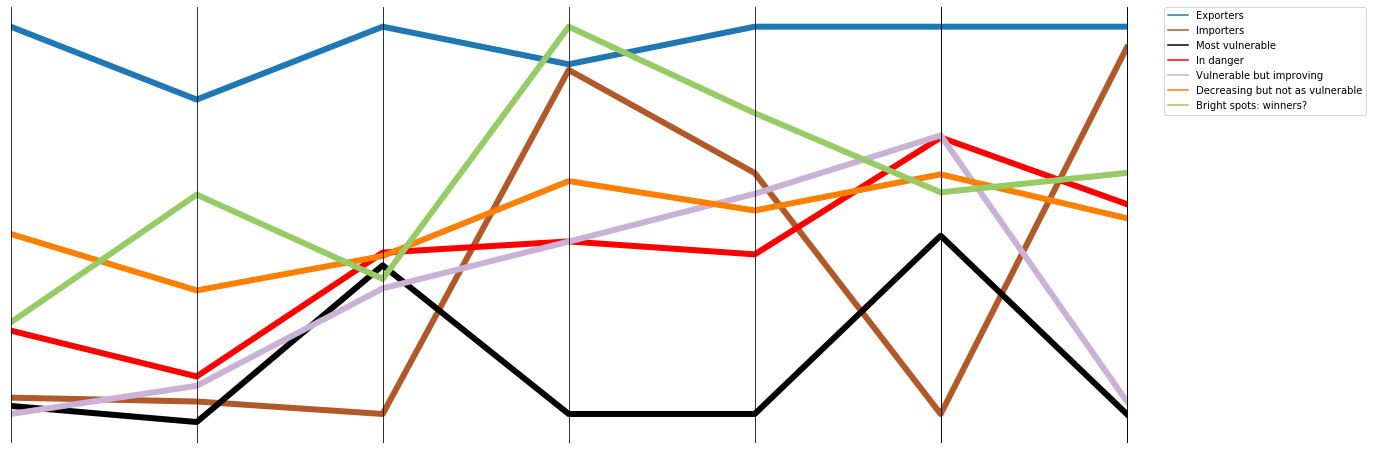

In [17]:
columns = ['CalSuff_2000', 'avg_new_suff', 'trade', 'GFSI', 'nutrition', 'water', 'GNP', 'Category']

plot_parallel_coord(averaged, columns, 'Category')
plt.savefig(figures_path + 'parallel_coord_gnp_nolog.png', transparent=True, dpi=500)

In [24]:
def plot_parallel_coord_all_countries(data, columns, index):
    cols = columns.copy()
    df = data[cols].copy()
    cols.remove(index)
    x = [i for i, _ in enumerate(cols)]
    colours = color_map

    # create dict of categories: colours
    colours = {cat_order[i]: colours[i] for i, _ in enumerate(cat_order)}


    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(20, 8))

    
    min_max_range = {}
    for col in cols:
        if col == 'CalSuff_2000':
            min_2000 = df['CalSuff_2000'].min()
            range_2000 = np.ptp(df['CalSuff_2000'])
        if col == 'avg_new_suff':
            min_max_range[col] = min_max_range['CalSuff_2000']
            df[col] = np.true_divide(df[col] - min_2000, range_2000)
        else:
            min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
            df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))
    
    # Plot each category
    for i, ax in enumerate(axes):
        for cat in cat_order:
            cat_points = df[df[index] == cat][cols]
            sns.lineplot(x*len(cat_points), cat_points.values.flatten(), linewidth=6, color=colours[cat], ax=ax, ci='sd', estimator='mean')
        ax.set_xlim([x[i], x[i+1]])
    

    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        col_name = cols[dim]
        if col_name == 'avg_new_suff':
            norm_min = df['CalSuff_2000'].min()
            norm_range = np.ptp(df['CalSuff_2000'])
            norm_step = norm_range / float(ticks-1)
        else:
            norm_min = df[cols[dim]].min()
            norm_range = np.ptp(df[cols[dim]])
            norm_step = norm_range / float(ticks-1)
            
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)
        
        ax.tick_params(axis='both', which='both', labelsize=20)


        
        """ax.yaxis.set_ticks([])
        ax.set_yticklabels([])"""
        
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        
    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=2)
        ax.set_xticklabels([cols[dim]])
        
        ax.xaxis.set_visible(False)
        

    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=2)
    ax.set_xticklabels([cols[-2], cols[-1]])
    
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    """plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in set(df[index])],
        set(df[index]),
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
"""
    #plt.title("Values by category")

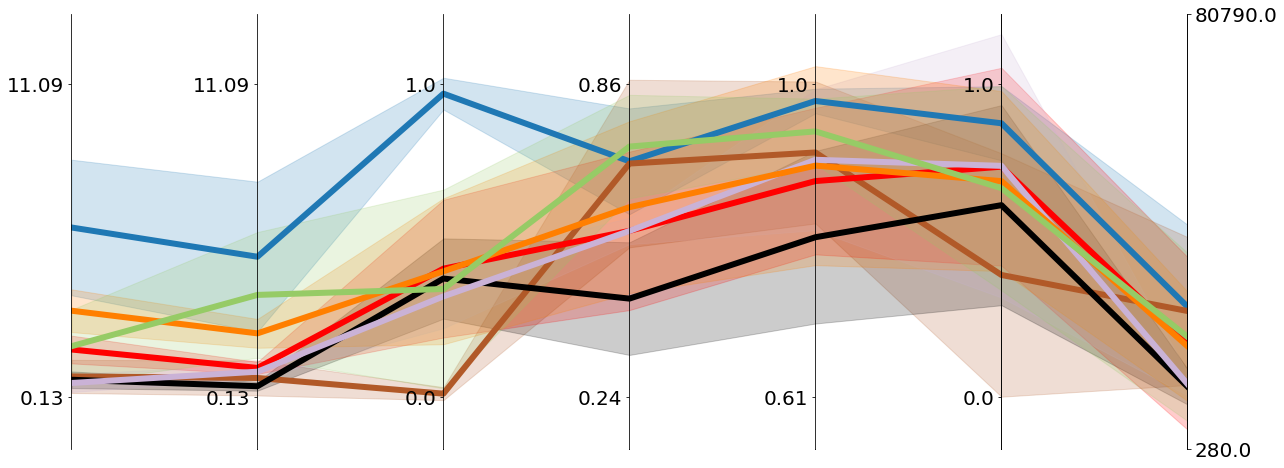

In [25]:
columns = ['CalSuff_2000', 'avg_new_suff', 'trade', 'GFSI', 'nutrition', 'water', 'GNP', 'Category']

all_countries = sufficiencies.set_index('Category').drop(['Outliers', 'Quite variable', 'No significant change']).reset_index()

plot_parallel_coord_all_countries(all_countries.reset_index(drop=True), columns, 'Category')
plt.savefig('Romain/figures/related_datasets/parallel_std.png', transparent=True, dpi=500)

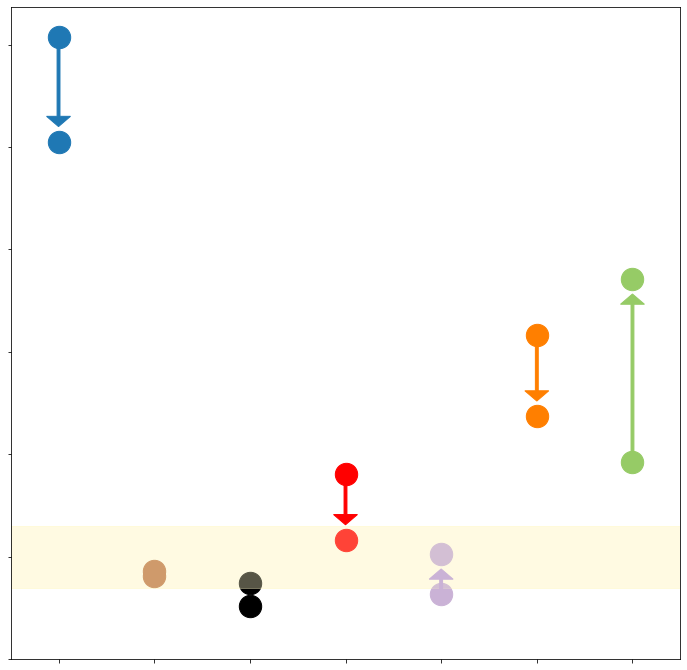

In [11]:
plt.figure(figsize=(12, 12))
plt.xlim(-0.5, len(averaged)-0.5)
plt.xticks(np.arange(len(averaged)), list(cat_order), rotation=20, fontsize=11)
plt.xticks(np.arange(len(averaged)), list([]))
#plt.ylabel('Average aloric sufficiency', fontsize=15)


for i, row in averaged.iterrows():
    colors = color_map
    plt.fill_between([-1, len(averaged)], 0.7, 1.3, color='lemonchiffon', alpha=0.1)
    if abs((row['avg_new_suff']-row['CalSuff_2000'])) > 0.3:
        plt.arrow(i, 
                  row['CalSuff_2000'], 
                  0, 
                  row['avg_new_suff']-row['CalSuff_2000'] - np.sign(row['avg_new_suff']-row['CalSuff_2000'])*0.25,
                  width=0.03, 
                  head_width=0.25, 
                  head_length=0.1, 
                  length_includes_head=False, 
                  alpha=1, 
                  color=colors[i])
    plt.scatter([i, i], row[['CalSuff_2000', 'avg_new_suff']], marker='o', label=row['Category'], s=500, c=colors[i])

    plt.yticks(np.arange(7), list([]))       
plt.savefig(figures_path + 'changes_cal_suff.png', transparent=True, dpi=500)

In [74]:
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return 2*h

In [75]:
confidence_interval(sufficiencies[sufficiencies['Category'] == 'Exporters']['CalSuff_2000'])

2.525707307230393

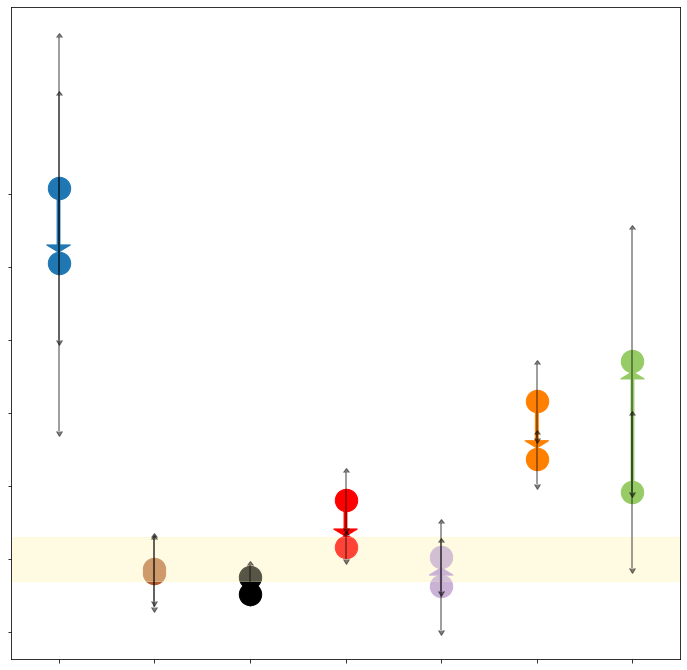

In [104]:
plt.figure(figsize=(12, 12))
plt.xlim(-0.5, len(averaged)-0.5)
plt.xticks(np.arange(len(averaged)), list(cat_order), rotation=20, fontsize=11)
plt.xticks(np.arange(len(averaged)), list([]))


for i, row in averaged.iterrows():
    colors = color_map
    plt.fill_between([-1, len(averaged)], 0.7, 1.3, color='lemonchiffon', alpha=0.1)
    if abs((row['avg_new_suff']-row['CalSuff_2000'])) > 0.3:
        plt.arrow(i, 
                  row['CalSuff_2000'], 
                  0, 
                  row['avg_new_suff']-row['CalSuff_2000'] - np.sign(row['avg_new_suff']-row['CalSuff_2000'])*0.25,
                  width=0.03, 
                  head_width=0.25, 
                  head_length=0.1, 
                  length_includes_head=False, 
                  alpha=1, 
                  color=colors[i])
    plt.scatter([i, i], row[['CalSuff_2000', 'avg_new_suff']], marker='o', label=row['Category'], s=500, c=colors[i])
    
    category = row['Category']
    length = confidence_interval(sufficiencies[sufficiencies['Category'] == category]['CalSuff_2000'], 0.9)
    plt.errorbar(i, row['CalSuff_2000'], length, uplims=True, lolims=True, ecolor='k', alpha=0.5)
    
    length = confidence_interval(sufficiencies[sufficiencies['Category'] == category]['avg_new_suff'], 0.9)
    plt.errorbar(i, row['avg_new_suff'], length, uplims=True, lolims=True, ecolor='k', alpha=0.5)
    
    plt.yticks(np.arange(7), list([]))       
plt.savefig('Romain/figures/related_datasets/changes_cal_suff_opt1.png', transparent=True, dpi=500)

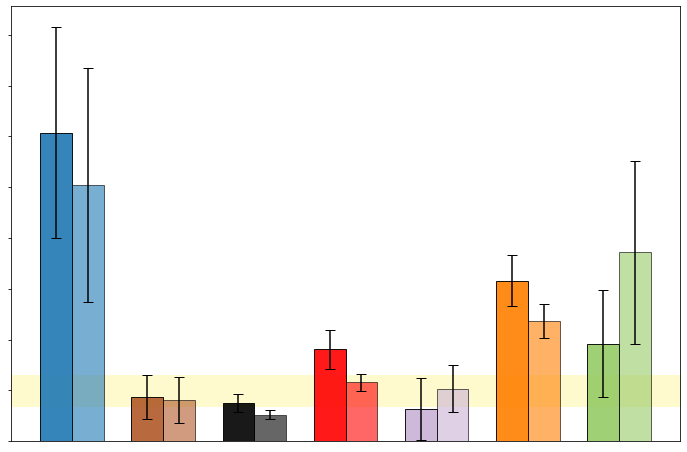

In [115]:
index = np.arange(len(cat_order))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-0.5, len(cat_order)+bar_width - 0.5)

intervals = [confidence_interval(sufficiencies[sufficiencies['Category'] == cat]['CalSuff_2000'], 0.9) for cat in cat_order]
"""intervals_1 = [(sufficiencies[sufficiencies['Category'] == cat]['CalSuff_2000']).quantile(0.25) for cat in cat_order]
intervals_2 = [(sufficiencies[sufficiencies['Category'] == cat]['CalSuff_2000']).quantile(0.75) for cat in cat_order]
intervals = [intervals_1, intervals_2]"""
actual = ax.bar(index, averaged['CalSuff_2000'].values, bar_width, yerr=intervals, capsize=5, color=color_map, edgecolor='k', alpha=0.9, label="Caloric sufficiency")

intervals = [confidence_interval(sufficiencies[sufficiencies['Category'] == cat]['avg_new_suff'], 0.9) for cat in cat_order]
"""intervals_1 = [(sufficiencies[sufficiencies['Category'] == cat]['avg_new_suff']).quantile(0.25) for cat in cat_order]
intervals_2 = [(sufficiencies[sufficiencies['Category'] == cat]['avg_new_suff']).quantile(0.75) for cat in cat_order]
intervals = [intervals_1, intervals_2]"""
future = ax.bar(index+bar_width, averaged['avg_new_suff'].values, bar_width, yerr=intervals, capsize=5, color=color_map, edgecolor='k', alpha=0.6, label="Future caloric sufficiency")

#ax.set_xlabel('Category')
#ax.set_ylabel('Incidence')
#ax.set_title('Crime incidence by season, type')
#ax.set_xticks(index + bar_width / 2)
ax.set_xticks([])
#ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.legend()

ax.fill_between([-0.5, len(averaged)], 0.7, 1.3, color='lemonchiffon')

plt.savefig('Romain/figures/related_datasets/changes_cal_suff_opt2.png', transparent=True, dpi=500)

# Correlations

In [19]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_full.csv')

In [20]:
sufficiencies.columns

Index(['ISO3', 'CalSuff_2000', 'ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5',
       'delta_consistency', 'trade', 'name', 'GFSI', 'GDP', 'log_GDP', 'GNP',
       'log_GNP', 'IncomeGroup', 'water', 'nutrition', 'avg_new_suff',
       'delta_CalSuff_avg', 'delta_max', 'lowest_ssp', 'highest_ssp',
       'Category'],
      dtype='object')

In [21]:
# 2000 with trade
index = sufficiencies['trade'].dropna().index
pearsonr(sufficiencies.loc[index, 'CalSuff_2000'], sufficiencies.loc[index, 'trade'])

(0.6076000627969113, 4.233922275030364e-16)

In [22]:
# 2000 with GFSI
index = sufficiencies['GFSI'].dropna().index
pearsonr(sufficiencies.loc[index, 'CalSuff_2000'], sufficiencies.loc[index, 'GFSI'])

(0.3420017101687113, 0.00029153633457190903)

In [23]:
# 2000 with malnutrition
index = sufficiencies['nutrition'].dropna().index
pearsonr(sufficiencies.loc[index, 'CalSuff_2000'], 1 - sufficiencies.loc[index, 'nutrition'])

(-0.2506596241091586, 0.004168468640365948)